In [52]:
from tensorboard.backend.event_processing import event_accumulator
import tensorflow_io
import pandas as pd
import os
import matplotlib.pyplot as plt

In [5]:
log_dir = "s3://bukovec-ml-data/logs/vim-fs-20-10-bce-reg/lightning_logs"
ea = event_accumulator.EventAccumulator(log_dir)
ea.Reload()

In [26]:
ea.Tags()

{'images': [],
 'audio': [],
 'histograms': [],
 'scalars': [],
 'distributions': [],
 'tensors': [],
 'graph': False,
 'meta_graph': False,
 'run_metadata': []}

In [6]:
# lining up experiments w/ final pl experiment numbers
experiments = {
    'vim-fs-20-10': 7,

    'vim-fs-20-10-bce': 14,
    'vim-fs-20-10-bce-reg': 2,
    'vim-fs-20-10-bce-aug': 0,
    'vim-fs-20-10-bce-reg-aug': 4,

    'vim-fs-20-10-bce-sm4': 0,
    'vim-fs-20-10-bce-sm4-aug': 0,

    'vim-fs-20-10-bce-sm4-resid': 0,
    'vim-fs-20-10-bce-sm4-resid-reg': 0,
    'vim-fs-20-10-bce-sm4-resid-aug': 2,
    'vim-fs-20-10-bce-sm4-resid-reg-aug': 1,

    'vim-fs-20-20-bce-sm4-resid-aug': 0,
    'vim-fs-280-1-bce-sm4-resid-aug': 0,
    'vim-fs-35-10-bce-sm4-resid-aug': 0,
    'vim-fs-56-5-bce-sm4-resid-aug': 0,

    'vim-fs-280-1-bce-aug': 0,
    'vim-fs-56-5-bce-aug': 0,
    'vim-fs-20-20-bce-aug': 0,
    'vim-fs-35-20-bce-aug': 0,
    'vim-fs-40-40-bce-aug': 0,
}

In [7]:
keys = ['train_loss_epoch', 'train_class_loss_epoch', 'train_seg_loss_epoch', 'val_loss', 'val_score', 'val_class_loss', 'val_seg_loss', 'val_class_acc', 'val_seg_f1', 'val_seg_prec', 'val_seg_recall']
data = []
for e in experiments:
    ea = event_accumulator.EventAccumulator(f"s3://bukovec-ml-data/logs/{e}/lightning_logs/version_{experiments[e]}")
    ea.Reload()
    d = {'experiment': e}
    for k in keys:
        d[k] = max(ea.Scalars(k), key=lambda x: x.step).value
    data.append(d)
data_df = pd.DataFrame(data)

In [9]:
stat_max = lambda x: data_df.loc[data_df[x].idxmax()]['experiment']
stat_min = lambda x: data_df.loc[data_df[x].idxmin()]['experiment']

In [10]:
for loss in ['train_loss_epoch','train_loss_epoch', 'train_class_loss_epoch', 'train_seg_loss_epoch', 'val_loss', 'val_class_loss', 'val_seg_loss']:
        print(f"Minimum {loss}: {stat_min(loss)}")
for stat in ['val_score', 'val_class_acc', 'val_seg_f1', 'val_seg_prec', 'val_seg_recall']:
    print(f"Maximum {stat}: {stat_max(stat)}")

Minimum train_loss_epoch: vim-fs-280-1-bce-sm4-resid-aug
Minimum train_loss_epoch: vim-fs-280-1-bce-sm4-resid-aug
Minimum train_class_loss_epoch: vim-fs-20-20-bce-sm4-resid-aug
Minimum train_seg_loss_epoch: vim-fs-280-1-bce-sm4-resid-aug
Minimum val_loss: vim-fs-280-1-bce-aug
Minimum val_class_loss: vim-fs-280-1-bce-aug
Minimum val_seg_loss: vim-fs-20-10
Maximum val_score: vim-fs-20-20-bce-aug
Maximum val_class_acc: vim-fs-280-1-bce-aug
Maximum val_seg_f1: vim-fs-20-20-bce-aug
Maximum val_seg_prec: vim-fs-56-5-bce-sm4-resid-aug
Maximum val_seg_recall: vim-fs-20-20-bce-aug


In [12]:
augs = ['vim-fs-20-10-bce-aug', 'vim-fs-20-10-bce-reg-aug', 'vim-fs-20-10-bce-sm4-aug', 'vim-fs-20-10-bce-sm4-resid-aug', 'vim-fs-20-10-bce-sm4-resid-reg-aug']
non_augs = ['vim-fs-20-10-bce', 'vim-fs-20-10-bce-reg', 'vim-fs-20-10-bce-sm4', 'vim-fs-20-10-bce-sm4-resid', 'vim-fs-20-10-bce-sm4-resid-reg']

/var/folders/n6/x9pnrbt9113f5qf4r_n1l4dm0000gn/T/ipykernel_55706/3143060918.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  augs_df.loc[:, "augmented"] = augs_df['experiment'].str.contains("aug")


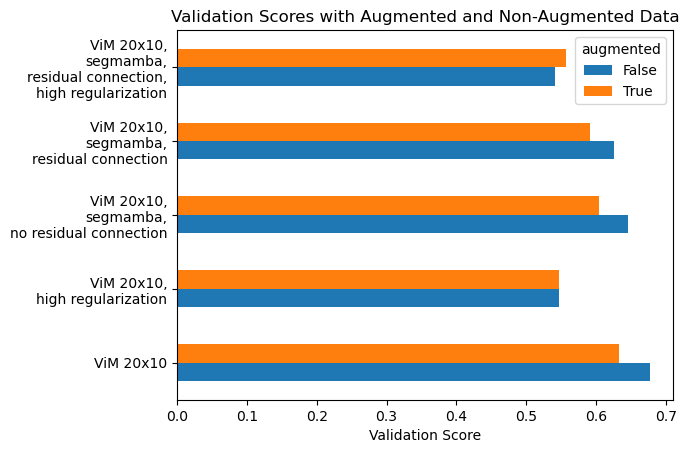

In [63]:
name_map = {
    'vim-fs-20-10-bce': 'ViM 20x10',
    'vim-fs-20-10-bce-reg': 'ViM 20x10,\nhigh regularization',
    'vim-fs-20-10-bce-sm4': 'ViM 20x10,\nsegmamba,\nno residual connection',
    'vim-fs-20-10-bce-sm4-resid': 'ViM 20x10,\nsegmamba,\nresidual connection',
    'vim-fs-20-10-bce-sm4-resid-reg': 'ViM 20x10,\nsegmamba,\nresidual connection,\nhigh regularization'
}
augs_df = data_df[data_df['experiment'].isin(augs + non_augs)]
augs_df.loc[:, "augmented"] = augs_df['experiment'].str.contains("aug")
augs_df.loc[:, "experiment"] = augs_df['experiment'].str.removesuffix("-aug")
augs_df.loc[:, "experiment"] = augs_df.loc[:, "experiment"].apply(lambda x: name_map[x])
augs_df = augs_df[['experiment', 'augmented', 'val_score']].pivot(index="experiment", columns="augmented", values="val_score")

augs_df.plot.barh(title="Validation Scores with Augmented and Non-Augmented Data")
plt.ylabel("")
plt.xlabel("Validation Score")

plt.savefig('data-aug-barh', bbox_inches='tight', transparent="True", pad_inches=0)

In [55]:
data_df[data_df['experiment'] == 'vim-fs-20-10-bce-sm4-resid-aug']

,experiment,train_loss_epoch,train_class_loss_epoch,train_seg_loss_epoch,val_loss,val_score,val_class_loss,val_seg_loss,val_class_acc,val_seg_f1,val_seg_prec,val_seg_recall
8,vim-fs-20-10-bce-sm4-resid-aug,0.000879,0.000072,0.001226,1.025683,0.590628,2.134819,0.550339,0.69,0.54804,0.720953,0.462431


In [57]:
data_df[data_df['experiment'] == 'vim-fs-35-10-bce-sm4-resid-aug']

,experiment,train_loss_epoch,train_class_loss_epoch,train_seg_loss_epoch,val_loss,val_score,val_class_loss,val_seg_loss,val_class_acc,val_seg_f1,val_seg_prec,val_seg_recall
12,vim-fs-35-10-bce-sm4-resid-aug,0.00106,0.001276,0.000968,0.82153,0.666284,1.624368,0.477457,0.743333,0.633262,0.755327,0.559461


In [66]:
dogwater = data_df.sort_values(by='val_score', ascending=False)[['experiment', 'val_loss', 'val_score', 'val_class_acc', 'val_seg_f1']]

In [67]:
print(dogwater.to_latex(float_format='%0.3f'))

\begin{tabular}{llrrrr}
\toprule
 & experiment & val_loss & val_score & val_class_acc & val_seg_f1 \\
\midrule
17 & vim-fs-20-20-bce-aug & 0.686 & 0.746 & 0.822 & 0.714 \\
15 & vim-fs-280-1-bce-aug & 0.584 & 0.732 & 0.848 & 0.682 \\
16 & vim-fs-56-5-bce-aug & 0.714 & 0.724 & 0.793 & 0.694 \\
14 & vim-fs-56-5-bce-sm4-resid-aug & 0.698 & 0.721 & 0.777 & 0.698 \\
11 & vim-fs-20-20-bce-sm4-resid-aug & 0.799 & 0.713 & 0.807 & 0.673 \\
12 & vim-fs-280-1-bce-sm4-resid-aug & 0.596 & 0.694 & 0.815 & 0.642 \\
1 & vim-fs-20-10-bce & 0.716 & 0.677 & 0.763 & 0.640 \\
13 & vim-fs-35-10-bce-sm4-resid-aug & 0.822 & 0.666 & 0.743 & 0.633 \\
18 & vim-fs-35-20-bce-aug & 0.900 & 0.650 & 0.765 & 0.601 \\
5 & vim-fs-20-10-bce-sm4 & 0.878 & 0.646 & 0.722 & 0.614 \\
3 & vim-fs-20-10-bce-aug & 0.866 & 0.633 & 0.730 & 0.591 \\
19 & vim-fs-40-40-bce-aug & 0.905 & 0.631 & 0.742 & 0.583 \\
7 & vim-fs-20-10-bce-sm4-resid & 1.041 & 0.626 & 0.707 & 0.591 \\
6 & vim-fs-20-10-bce-sm4-aug & 1.030 & 0.604 & 0.710 & 0.559

In [1]:
data = pd.read_csv('src/stats/experiments_stats.csv')

NameError: name 'pd' is not defined